# import dependencies

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
from pandas.plotting import scatter_matrix
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [5]:
data = []
fileNum = 2
while fileNum < 115: 
    with open('data/logs-insights-results-' + str(fileNum) + '.csv') as f:
        for line in csv.DictReader(f, fieldnames=('timestamp', 'message')):
            data.append(line)
        fileNum += 1

In [6]:
len(data)

822226

## This decodes to message into different attributes:
#### account: the account of the user 
#### sourceIP: the ip address of the sender of the message
#### destIP: the receiver of the message
#### interface: the log stream of the message
#### srcPort: internet port of sender
#### dstPort: internet port of receiver
#### protocol: the network protocol used to communicate the message
#### byte: the size of the message
#### packets: number of segments of the message
#### startTime: the integer start time in unix time form
#### timeTook: exact time it took to send the message
#### status: either "ACCEPT" or "REJECT". Accept will be 1 and reject will be represented as 0.

In [7]:
date = []
time = []
account = []
sourceIP = []
destIP = []
interface = []
srcPort = []
dstPort = []
protocol = []
byte = []
packets = []
startTime = []
timeTook = []
status = []

na = None
i = 1

while i < len(data):
    msg = data[i].get('message',na)
    # for messages with no data will get filtered out here
    if 'ACCEPT' in msg or 'REJECT' in msg:
        timeTokens = data[i].get('timestamp',na).split()
        date.append(timeTokens[0])
        time.append(timeTokens[1])
        tokens = msg.split()
        account.append(tokens[1])
        interface.append(tokens[2])
        sourceIP.append(tokens[3])
        destIP.append(tokens[4])
        #storing actions
        temp = 5
        tempStr = ''
        while(tokens[temp+1] != "OK"):
            tempStr = tempStr + tokens[temp] + ' '
            temp += 1
        actionTokens = tempStr.split()
        srcPort.append(actionTokens[0])
        dstPort.append(actionTokens[1])
        protocol.append(actionTokens[2])
        packets.append(actionTokens[3])
        byte.append(actionTokens[4])
        startTime.append(int(actionTokens[5]))
        timeTook.append(int(actionTokens[6]) - int(actionTokens[5]))
        if(tokens[temp] == 'ACCEPT'):
            status.append(1)
        else:
            status.append(0)
    i += 1
# print label as well
print('Date: ' + date[0])
print('Time: ' + time[0])
print('AWS account: ' + account[0])
print('Network interface: ' + interface[0])
print('Source IP: ' + sourceIP[0])
print('Destination IP: ' + destIP[0])
print('Status: ' + str(status[0]))
print('Source port: ' + srcPort[0])
print('Destination port: ' + dstPort[0])
print('Protocol: ' + protocol[0])
print('Packets of data: ' + packets[0])
print('Size of data: ' + byte[0] + ' bytes')
print('Start time: ' + str(startTime[0]))
print('Time used: ' + str(timeTook[0]) + ' seconds')
print('New size of dataset after filtering: ' + str(len(date)))

Date: 2021-02-10
Time: 18:15:00.000
AWS account: 430405884063
Network interface: eni-0b6ce86ea40aaa41b
Source IP: 50.245.225.205
Destination IP: 172.16.1.52
Status: 1
Source port: 9622
Destination port: 80
Protocol: 6
Packets of data: 5
Size of data: 582 bytes
Start time: 1612980900
Time used: 9 seconds
New size of dataset after filtering: 813100


In [8]:
df = pd.DataFrame({
    "date":date,
    "time":time,
    "account":account,
    "interface":interface,
    "sourceIP":sourceIP,
    "destIP":destIP,
    "srcPort":srcPort,
    "dstPort":dstPort,
    "protocol":protocol,
    "packets":packets,
    "byte":byte,
    "startTime":startTime,
    "timeTook":timeTook,
    "status":status
})

In [11]:
df.head(10)

,date,time,account,interface,sourceIP,destIP,srcPort,dstPort,protocol,packets,byte,startTime,timeTook,status
0,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,9622,80,6,5,582,1612980900,9,1
1,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,9622,6,5,689,1612980900,9,1
2,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,22050,80,6,6,648,1612980900,9,1
3,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,22050,6,5,582,1612980900,9,1
4,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,51466,80,6,8,723,1612980900,9,1
5,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,51466,6,11,10996,1612980900,9,1
6,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,49748,80,6,7,705,1612980900,9,1
7,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,49748,6,13,12958,1612980900,9,1
8,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,50.245.225.205,172.16.1.52,18681,80,6,5,572,1612980900,9,1
9,2021-02-10,18:15:00.000,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,18681,6,5,638,1612980900,9,1


In [12]:
df.columns

Index(['date', 'time', 'account', 'interface', 'sourceIP', 'destIP', 'srcPort',
       'dstPort', 'protocol', 'packets', 'byte', 'startTime', 'timeTook',
       'status'],
      dtype='object')

Remove unneeded Collumns

In [13]:
df.pop('date')
df.pop('time')
df.pop("account")
df.pop("interface")
df.pop('srcPort')
df.pop('dstPort')
df.pop('protocol')
df.pop('packets')
df.pop('byte')
df.pop('timeTook')

# Reformat numbers
df['startTime'] = pd.to_numeric(df['startTime'])
df['status'] = pd.to_numeric(df['status'])

df.head()

,sourceIP,destIP,startTime,status
0,50.245.225.205,172.16.1.52,1612980900,1
1,172.16.1.52,50.245.225.205,1612980900,1
2,50.245.225.205,172.16.1.52,1612980900,1
3,172.16.1.52,50.245.225.205,1612980900,1
4,50.245.225.205,172.16.1.52,1612980900,1


In [14]:
df = df.sort_values(['startTime','sourceIP', 'destIP',],ascending=[True, True, True])
df = df.reset_index(drop=True)
df.head()

,sourceIP,destIP,startTime,status
0,172.16.1.196,172.16.1.52,1612980720,1
1,172.16.1.196,172.16.1.52,1612980720,1
2,172.16.1.196,172.16.1.52,1612980720,1
3,172.16.1.196,172.16.1.52,1612980720,1
4,172.16.1.196,172.16.1.52,1612980720,1


Because an attacked is considered as an abnormal behavior in the dataset which the number of requests from a single ip address is much greater than the average. We pre-process the data by combining the rows if the source IP, destination IP, and start time are the same, creating a new column called numOfRequest that keeps track of the number of duplicate requests for each second.

In [15]:
#preprocess the data
#O(n)
processedDf = pd.DataFrame({
    "sourceIP":[],
    "destIP":[],
    "numOfRequest":[],
    "time":[],
    "acceptanceRate":[],
})
for index, line in df.iterrows():
    if index == 0:
        m = 100
        if line['status'] == 0:
            m = 0
        processedDf.loc[0] = [line['sourceIP'],line['destIP'],1,line['startTime'],m]
    else:
        n = len(processedDf)-1
        if processedDf.loc[n,'sourceIP']==line['sourceIP'] and processedDf.loc[n,'destIP']==line['destIP'] and processedDf.loc[n,'time']==line['startTime']:
            x = processedDf.loc[n,'numOfRequest']
            processedDf.loc[n,'numOfRequest'] = x + 1
            if line['status'] == 1:
                processedDf.loc[n,'acceptanceRate'] = (((x*processedDf.loc[n,'acceptanceRate']*0.01)+1)/(x+1)) * 100
            else:
                processedDf.loc[n,'acceptanceRate'] = (((x*processedDf.loc[n,'acceptanceRate']*0.01))/(x+1)) * 100
        else:
            m = 100
            if line['status'] == 0:
                m = 0
            processedDf.loc[n+1] = [line['sourceIP'],line['destIP'],1,line['startTime'],m]
processedDf.head()

,sourceIP,destIP,numOfRequest,time,acceptanceRate
0,172.16.1.196,172.16.1.52,5.0,1.612981e+09,100.0
1,172.16.1.52,172.16.1.196,5.0,1.612981e+09,100.0
2,172.16.1.52,50.230.35.38,4.0,1.612981e+09,100.0
3,50.230.35.38,172.16.1.52,4.0,1.612981e+09,100.0
4,10.3.252.99,172.16.1.196,5.0,1.612981e+09,100.0


In [16]:
processedDf.to_csv('processed_data.csv')

View data to determine correlations, groupings, outliers, and any other trends (only 5% of the data graphed)

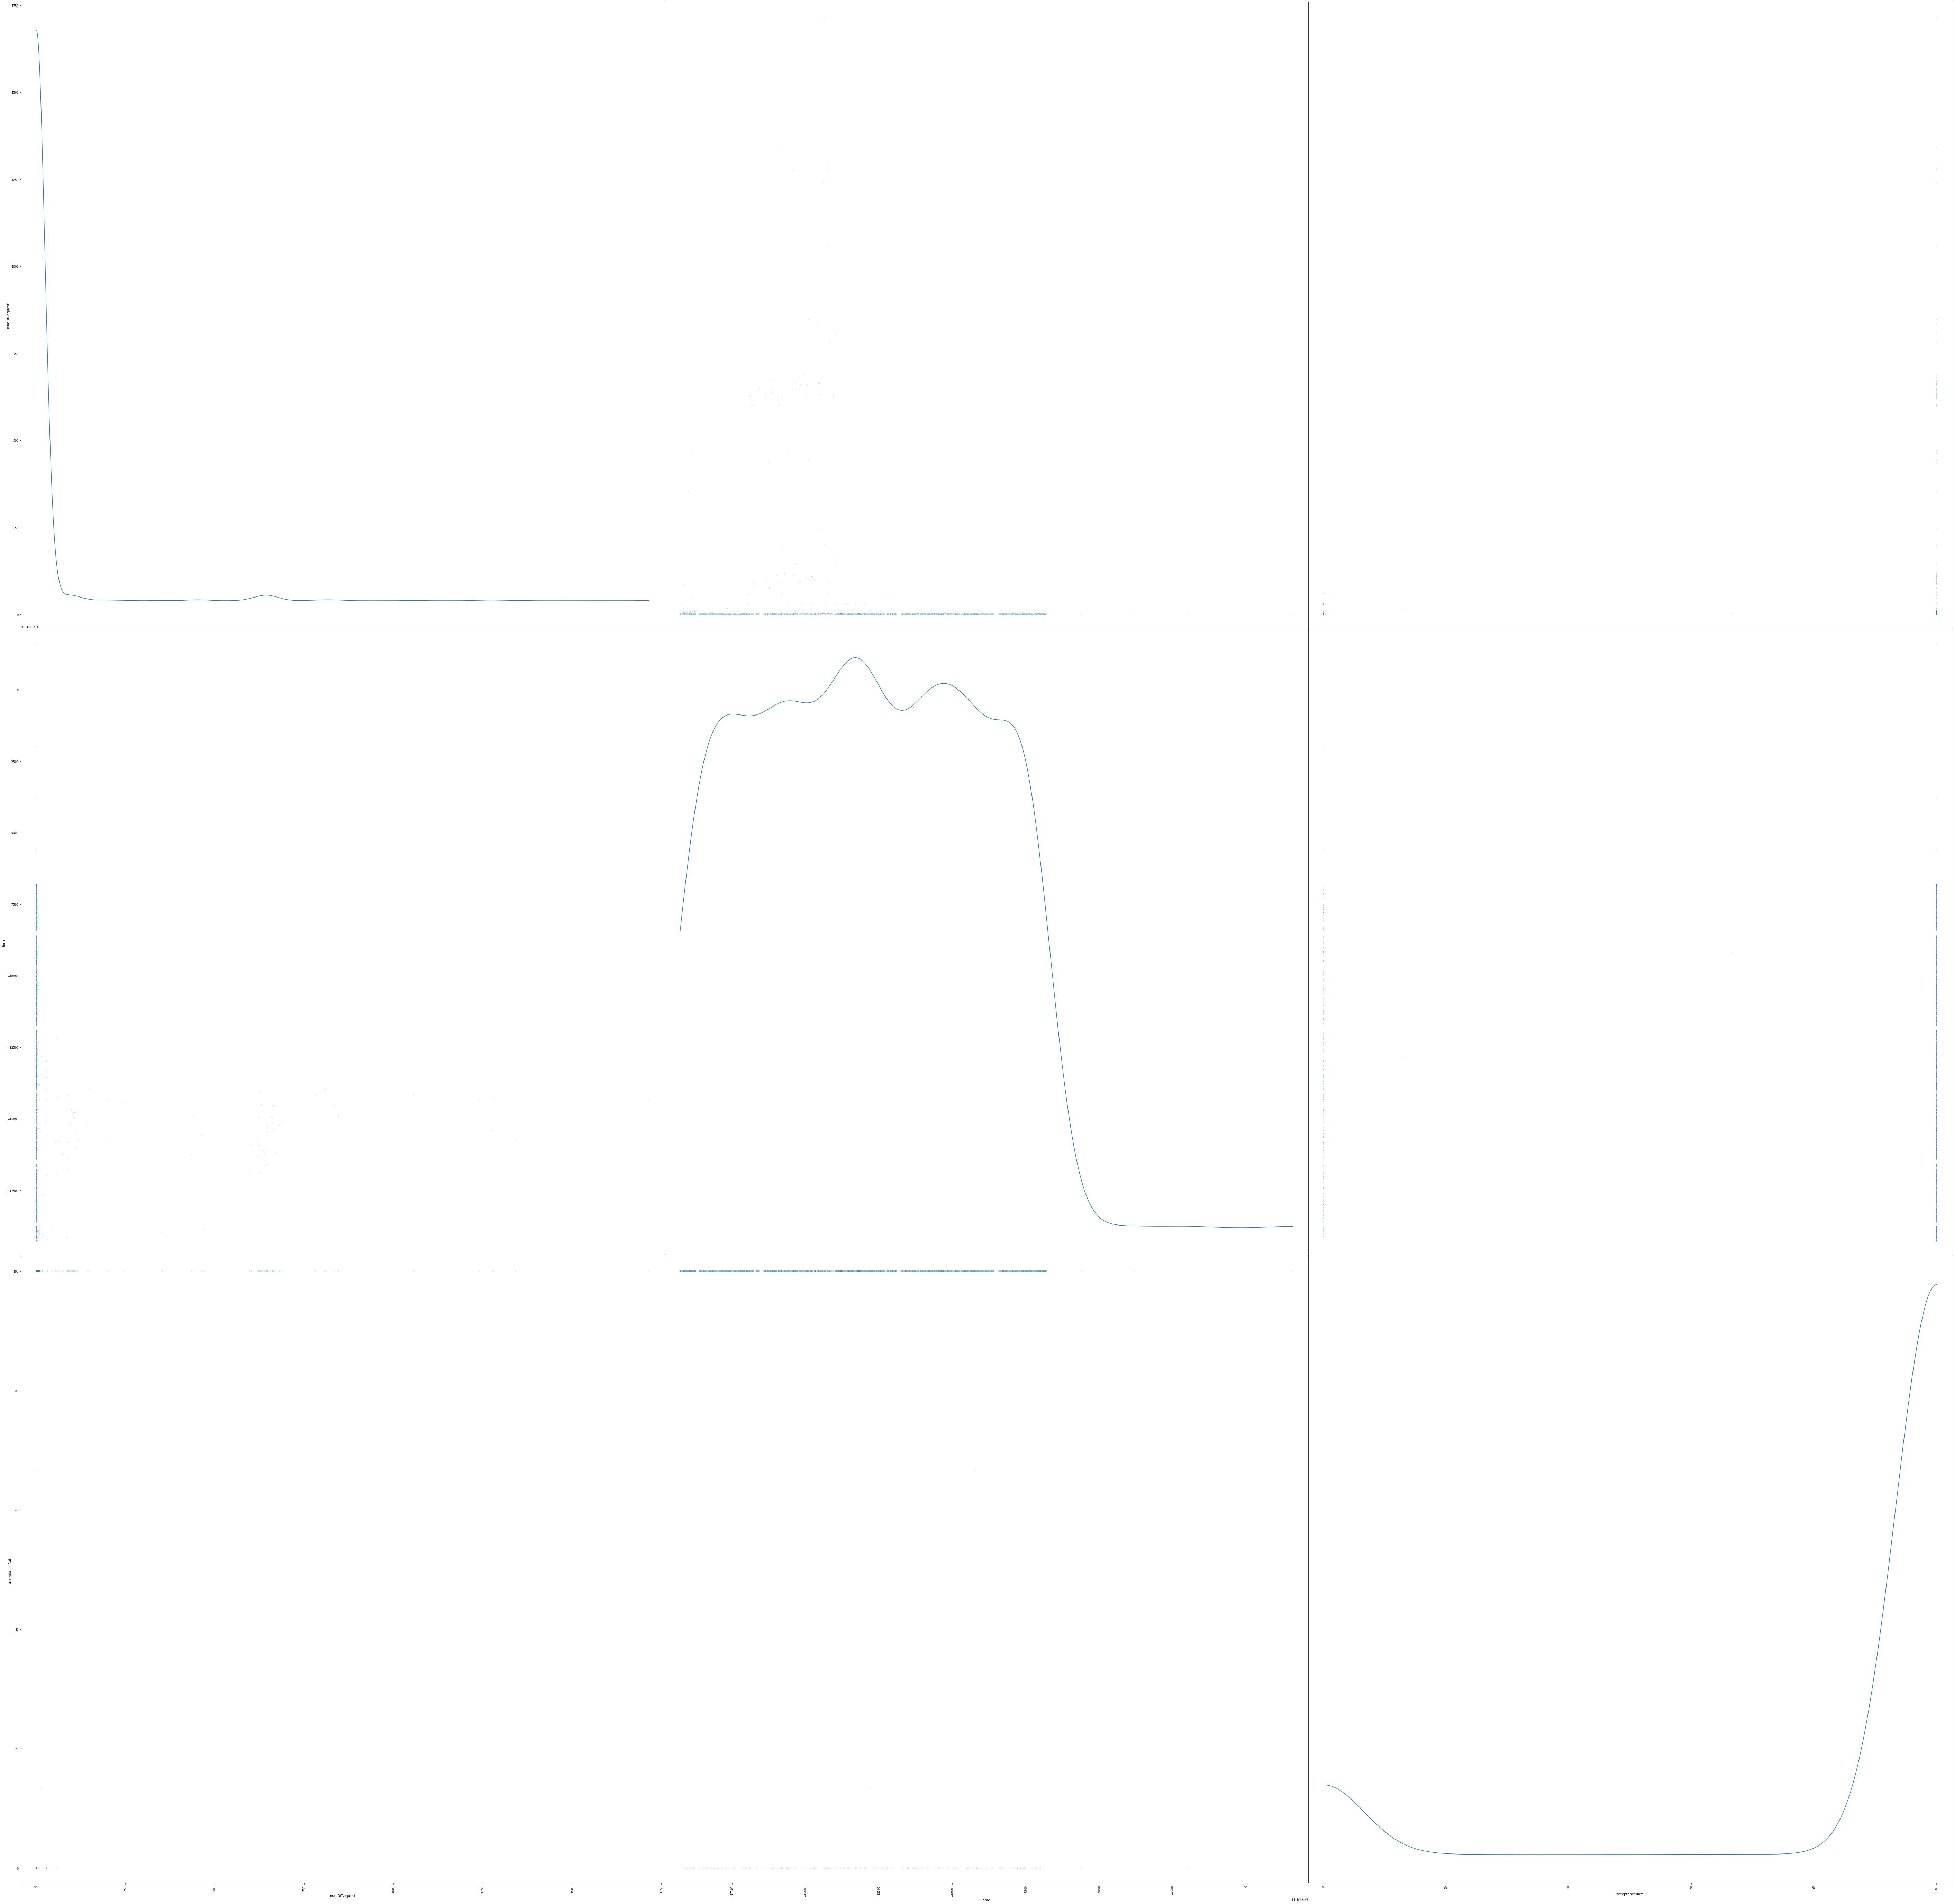

In [17]:
fig = scatter_matrix(processedDf.sample(frac=0.05), alpha=0.2,figsize=(100,100), diagonal="kde")  

In [18]:
df = processedDf    

Because the dataset does not contain a supervised information to determine the response being whether an attack, unsupervised machine learning is used to determine the attacks and not attacks. KMeans clustering groups the the dataset around 2 centroids. Then, logistic regression is used to produce the likeihood of each response being an attack by the machine. The K-mean cluster result is used as a superviser for the logictic regression.

In [19]:
from numpy import nan
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# This is our dataset to train, tweak, and test our model on.
X = df.loc[:, ['numOfRequest', 'acceptanceRate']]

kmeans = KMeans(n_clusters = 2) # is attack or not attack into 2 clusters
kmeans.fit(X)
df['is_attack'] = kmeans.labels_

y = df['is_attack'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, verbose=1).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14418
           1       1.00      1.00      1.00       272

    accuracy                           1.00     14690
   macro avg       1.00      1.00      1.00     14690
weighted avg       1.00      1.00      1.00     14690



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


The report above indicated that there are 14386 responsed considered as not attacks, and 288 as attacks.

In [20]:
df['probabilityOfAttack'] = clf.predict_proba(X)[:,1]
df.head()

,sourceIP,destIP,numOfRequest,time,acceptanceRate,is_attack,probabilityOfAttack
0,172.16.1.196,172.16.1.52,5.0,1.612981e+09,100.0,0,8.451097e-160
1,172.16.1.52,172.16.1.196,5.0,1.612981e+09,100.0,0,8.451097e-160
2,172.16.1.52,50.230.35.38,4.0,1.612981e+09,100.0,0,3.131798e-160
3,50.230.35.38,172.16.1.52,4.0,1.612981e+09,100.0,0,3.131798e-160
4,10.3.252.99,172.16.1.196,5.0,1.612981e+09,100.0,0,8.451097e-160


Here is the sorted dataset based on the probability of attacks, the result is showing that for over a few hundred responses in 1 second are highly considered an attack.

In [21]:
attacks = df.sort_values(by='probabilityOfAttack',ascending=False)
attacks = attacks[attacks['probabilityOfAttack']==1]
attacks.to_csv('attacks.csv')
attacks.head()

,sourceIP,destIP,numOfRequest,time,acceptanceRate,is_attack,probabilityOfAttack
10907,172.16.1.52,172.16.1.196,622.0,1.612984e+09,100.0,1,1.0
14459,172.16.1.196,172.16.1.52,674.0,1.612985e+09,100.0,1,1.0
14407,172.16.1.196,172.16.1.52,655.0,1.612985e+09,100.0,1,1.0
14399,172.16.1.52,172.16.1.196,650.0,1.612985e+09,100.0,1,1.0
14397,172.16.1.196,172.16.1.52,650.0,1.612985e+09,100.0,1,1.0


The threshold for the number of requests considered as an attack is 410 per second

In [22]:
attacks.sort_values(by='numOfRequest',ascending=True)

,sourceIP,destIP,numOfRequest,time,acceptanceRate,is_attack,probabilityOfAttack
11651,172.16.1.196,172.16.1.52,414.0,1.612984e+09,100.000000,1,1.0
15366,172.16.1.52,172.16.1.196,414.0,1.612985e+09,100.000000,1,1.0
11653,172.16.1.52,172.16.1.196,414.0,1.612984e+09,100.000000,1,1.0
15365,172.16.1.196,172.16.1.52,414.0,1.612985e+09,100.000000,1,1.0
862,172.16.1.52,50.245.225.205,416.0,1.612981e+09,100.000000,1,1.0
...,...,...,...,...,...,...,...
16871,172.16.1.52,172.16.1.196,1866.0,1.612986e+09,100.000000,1,1.0
15122,10.3.252.33,172.16.1.241,1965.0,1.612985e+09,0.152672,1,1.0
18923,10.3.252.33,172.16.1.241,2034.0,1.612986e+09,0.245821,1,1.0
17696,172.16.1.196,172.16.1.52,2410.0,1.612986e+09,100.000000,1,1.0


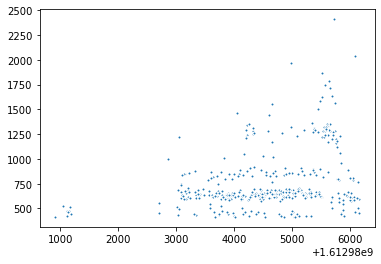

In [23]:
plt.scatter(attacks['time'], attacks['numOfRequest'], marker='.', edgecolors='white')
plt.show()

In [24]:
df.to_csv('result.csv')

X. Gong et al., "Estimating Web Attack Detection via Model Uncertainty from Inaccurate Annotation," 2019 6th IEEE International Conference on Cyber Security and Cloud Computing (CSCloud)/ 2019 5th IEEE International Conference on Edge Computing and Scalable Cloud (EdgeCom), 2019, pp. 53-58, doi: 10.1109/CSCloud/EdgeCom.2019.00019.

Z. Tian, C. Luo, J. Qiu, X. Du and M. Guizani, "A Distributed Deep Learning System for Web Attack Detection on Edge Devices," in IEEE Transactions on Industrial Informatics, vol. 16, no. 3, pp. 1963-1971, March 2020, doi: 10.1109/TII.2019.2938778.

Géron, Aurélien. Hands-on Machine Learning with SCIKIT-LEARN, Keras, and TENSORFLOW: Concepts, Tools, and Techniques to Build Intelligent Systems. O'Reilly, 2020. 

Torrano-Gimenez, C., Nguyen, H. T., Alvarez, G., and Franke, K. (2015) Combining expert knowledge with automatic feature extraction for reliable web attack detection. Security Comm. Networks, 8: 2750– 2767. doi: 10.1002/sec.603.

G. Betarte, Á. Pardo and R. Martínez, "Web Application Attacks Detection Using Machine Learning Techniques," 2018 17th IEEE International Conference on Machine Learning and Applications (ICMLA), 2018, pp. 1065-1072, doi: 10.1109/ICMLA.2018.00174.

http://www.jatit.org/volumes/Vol97No17/4Vol97No17.pdf

https://github.com/p-neumann/User-Behavior-Analysis-and-Prediction